# Certainty Threshold Analysis

In [1]:
import sys
sys.path.append('..')

## Load Data

In [2]:
import wfdb

def read_record(path, sampto=None):
    record = wfdb.rdrecord(path, sampto=sampto)
    annotation = wfdb.rdann(path, 'atr', sampto=sampto)
    trigger = trigger_points(annotation)
    return record, trigger

def read_records(directory, names, sampto=None):
    records, triggers = [], []
    for name in names:
        path = "/".join([directory, name])
        record, trigger = read_record(path, sampto)
        records.append(record)
        triggers.append(trigger)
    return records, triggers

In [3]:
import numpy as np
from raccoon.utils.annotationutils import trigger_points

# Clean ECG Signals
signal_dir = "../data/mitdb"
names = np.array([
    "100", "101", "102", "103", "104", "105", "106", "107", "108", "109"
])
sampto = 10000

clean_records, triggers = read_records(signal_dir, names, sampto)
clean_records, triggers = np.array(clean_records), np.array(triggers)

# Noise template
noise_path = '../data/noises/em'
noise_template = wfdb.rdrecord(noise_path)

## Add Noise

In [4]:
from raccoon.utils.noiseutils import apply_noise_db

snr = 6

noisy_records = np.array([
    apply_noise_db(clean_record, noise_template, snr)
    for clean_record in clean_records])

## Create Detector

In [5]:
from raccoon.detectors import XiangDetector

xd = XiangDetector(
    name='XD', batch_size=32, window_size=40, detection_size=30,
    aux_ratio=5, epochs=3)

Using TensorFlow backend.


## Helpers

In [6]:
def tp_contained(tp, trigger, tolerance):
    return any([abs(tp-ttp) < tolerance for ttp in trigger])

## Train and Test

In [7]:
from collections import defaultdict
from contextlib import redirect_stdout
from io import StringIO
from sklearn.model_selection import LeaveOneOut
from raccoon.utils.evaluationutils import trigger_metrics
from raccoon.utils.triggerutils import signal_to_points

dtriggers, certs, trues = [], [], []
cv = LeaveOneOut()

for step_id, (train_indexes, test_indexes) in enumerate(cv.split(names), start=1):
    print("Step {}/{}: {}".format(step_id, cv.get_n_splits(names), test_indexes))
    
    # Training
    train_records = clean_records[train_indexes]
    train_triggers = triggers[train_indexes]
    xd.reset()
    with redirect_stdout(StringIO()):
        xd.train(train_records, train_triggers)

    # Testing
    test_record = noisy_records[test_indexes][0]
    test_trigger = triggers[test_indexes][0]

    trigger_signal = xd.trigger_signal(test_record)
    trigger, cert = signal_to_points(
        trigger_signal, threshold=0.01, with_certainty=True)
    dtriggers.append(trigger)
    certs.append(cert)
    trues.append([tp_contained(tp, test_trigger, 5) for tp in trigger])

Step 1/10: [0]
Step 2/10: [1]
Step 3/10: [2]
Step 4/10: [3]
Step 5/10: [4]
Step 6/10: [5]
Step 7/10: [6]
Step 8/10: [7]
Step 9/10: [8]
Step 10/10: [9]


Text(0.5,0,'Certainty')

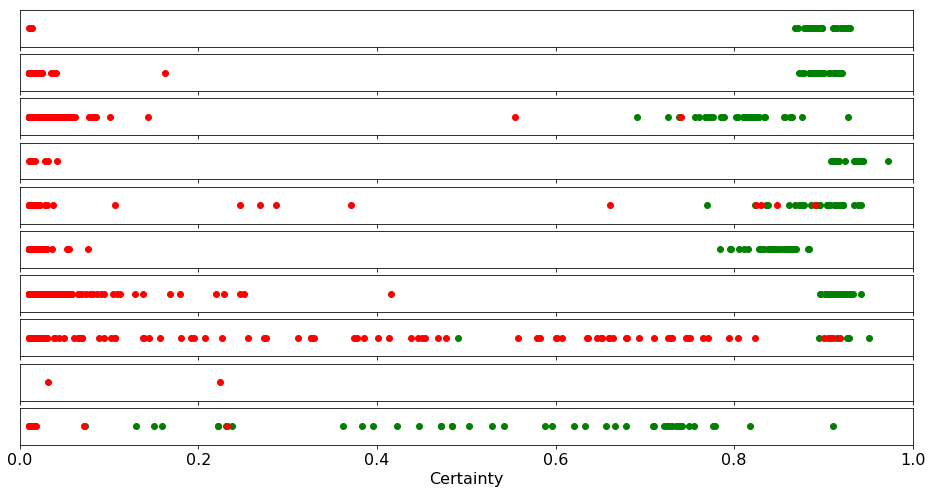

In [13]:
import matplotlib.pyplot as plt
from itertools import compress

plt.rcParams.update({'font.size': 16})

fig, axes = plt.subplots(nrows=10, sharex=True)
fig.set_size_inches(16,8)

for idx, ax in enumerate(axes):
    cert_true = list(compress(certs[idx], trues[idx]))
    cert_false = list(compress(certs[idx], np.logical_not(trues[idx])))
    
    ax.scatter(cert_true, np.zeros_like(cert_true), c='green')
    ax.scatter(cert_false, np.zeros_like(cert_false), c='red')
    ax.set_xlim(0,1)
    ax.set_yticks([])
    
axes[9].set_xlabel('Certainty')

In [14]:
save = False 

if save:
    fig.savefig(
        '../../msc-thesis/defense/images/ct_clusters.pdf',
        format='pdf',
        bbox_inches = 'tight',
        pad_inches = 0.1)